In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight

from Boosting_Functions import test_train_validation_split

In [2]:
def load_full_df():
    main_df = pd.read_csv("processed_wildfire_ERA5_FWI.csv",index_col=0)
    main_df['date'] = pd.to_datetime(main_df['date'])
    main_df.rename(columns={'latitude_ERA5': 'latitude', 'longitude_ERA5': 'longitude'},inplace=True)
    unnamed_cols = [col for col in main_df.columns if col.startswith('Unnamed:')]
    main_df.drop(columns=unnamed_cols, inplace=True)
    main_df['type_of_high_vegetation'] = main_df['type_of_high_vegetation'].astype(int)
    main_df['type_of_low_vegetation'] = main_df['type_of_low_vegetation'].astype(int)
    return main_df

main_df = load_full_df()

# Create the validation dataframe out of data after 2019
validation_df = main_df[main_df['date'] > pd.Timestamp('2019-01-01')]
test_train_df = main_df[main_df['date'] < pd.Timestamp('2019-01-01')]

# Splitting the dataset into training and validation sets
X_train, X_test, X_validation, y_train, y_test, y_validation = test_train_validation_split(validation_df, test_train_df, target_variable='fire', test_proportion=0.25)

In [17]:
X_train.describe()

,date,latitude,longitude,high_vegetation_cover,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,low_vegetation_cover,slope_of_sub_gridscale_orography,type_of_high_vegetation,type_of_low_vegetation,...,FFMC,FWI,fire_count_past_3Days,fire_count_past_7Days,fire_count_past_10Days,fire_count_past_30Days,24hr_max_temperature_1dayLag,24hr_max_temperature_2dayLag,global_noon_LST_2m_temperature_1dayLag,global_noon_LST_2m_temperature_2dayLag
count,2495036,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,...,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06,2.495036e+06
mean,2009-08-07 07:00:18.047354624,5.623946e+01,2.446334e+02,9.292609e-01,2.801871e+00,9.631446e-01,5.277399e-02,8.306079e-03,4.898259e+00,1.452553e+00,...,7.149515e+01,6.021335e+00,1.766347e-02,4.176773e-02,5.989533e-02,1.822615e-01,1.730255e+01,1.742635e+01,1.454512e+01,1.466425e+01
min,2000-04-02 00:00:00,4.900000e+01,2.400000e+02,0.000000e+00,0.000000e+00,-2.384186e-07,0.000000e+00,1.000017e-04,0.000000e+00,0.000000e+00,...,5.189555e-05,4.194940e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.211521e+01,-8.207080e+00,-1.727691e+01,-1.512716e+01
25%,2004-10-16 00:00:00,5.475000e+01,2.425000e+02,9.492317e-01,2.140011e+00,0.000000e+00,0.000000e+00,3.851585e-03,2.000000e+00,0.000000e+00,...,6.123323e+01,5.125167e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.309111e+01,1.325669e+01,1.028029e+01,1.045518e+01
50%,2009-08-02 00:00:00,5.650000e+01,2.445000e+02,9.974669e-01,2.744643e+00,3.692615e-01,1.831144e-03,5.965650e-03,5.000000e+00,0.000000e+00,...,7.990394e+01,3.389592e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.788215e+01,1.791431e+01,1.525052e+01,1.528962e+01
75%,2014-06-15 00:00:00,5.800000e+01,2.467500e+02,1.000000e+00,3.421463e+00,1.935937e+00,2.374378e-02,9.418227e-03,5.000000e+00,1.000000e+00,...,8.673745e+01,9.542098e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.197493e+01,2.197923e+01,1.931381e+01,1.932046e+01
max,2018-11-08 00:00:00,6.000000e+01,2.500000e+02,1.000000e+00,5.309044e+00,3.254241e+00,7.923489e-01,6.413157e-02,1.900000e+01,1.700000e+01,...,9.865962e+01,7.355980e+01,3.000000e+00,7.000000e+00,1.000000e+01,3.000000e+01,3.700391e+01,3.728909e+01,3.611697e+01,3.611697e+01
std,NaN,2.272372e+00,2.807980e+00,1.543380e-01,7.834476e-01,1.095909e+00,1.270852e-01,8.334924e-03,4.654850e+00,3.932152e+00,...,2.038248e+01,7.032173e+00,1.536147e-01,2.673681e-01,3.399600e-01,7.477496e-01,6.274064e+00,6.100648e+00,6.366771e+00,6.211763e+00


In [8]:
## Pipeline ##
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

## Preprocessing ##
# Define features to include #
pass_features = ['leaf_area_index_high_vegetation', 'slope_of_sub_gridscale_orography']
categorical_features = ['type_of_high_vegetation']
numeric_features = ['fire_count_past_10Days','DMC','global_noon_LST_2m_temperature','BUI',
                'FWI','latitude','FFMC','global_noon_LST_relative_humidity','24hr_max_temperature',
                'global_noon_LST_2m_temperature_1dayLag','global_noon_LST_2m_temperature_2dayLag',
                'high_vegetation_cover','24hr_max_temperature_1dayLag','low_vegetation_cover',
                '24hr_accumulated_precipitation']
####

# Define custom preprocessing functions. Put any custom functions in SVM_functions.py also so they are accessible by the ensemble
def extract_day_of_year(X):
    day_of_year = X['date'].dt.dayofyear.to_frame(name='day_of_the_year')
    return day_of_year

# Define numeric and categorical transformer below
date_transformer = ColumnTransformer([('date', FunctionTransformer(extract_day_of_year, validate=False), ['date'])], verbose_feature_names_out=False, remainder='passthrough').set_output(transform='pandas')
scale=ColumnTransformer([('scale_transformer',StandardScaler(),numeric_features)],verbose_feature_names_out=False).set_output(transform='pandas')
cate=ColumnTransformer([('categorical_transformer',OneHotEncoder(sparse_output=False),categorical_features)],verbose_feature_names_out=False).set_output(transform='pandas')
pss=ColumnTransformer([('Pass_transformer','passthrough',pass_features)],verbose_feature_names_out=False).set_output(transform='pandas')

feature_union = FeatureUnion([
    ('numeric', scale),
    ('categorical', cate),
    ('pass', pss),
])

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Classifier
base_estimator = DecisionTreeClassifier(max_depth=1, class_weight=class_weight_dict)
boosting_classifier = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, random_state=42)

# Final Pipeline (not including participant predictions)
boosting_pipeline = Pipeline([
    ('day_of_year', date_transformer),
    ('feature_union', feature_union),
    ('classifier', boosting_classifier)
])

In [15]:
# Training the model
boosting_pipeline.fit(X_train, y_train)

# Making predictions
y_pred = boosting_pipeline.predict(X_validation)

# Evaluating the model
print("Classification Report:")
print(classification_report(y_validation, y_pred))
print("F1 Score:", f1_score(y_validation, y_pred))



c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    179619
           1       0.02      0.60      0.03       752

    accuracy                           0.85    180371
   macro avg       0.51      0.73      0.48    180371
weighted avg       0.99      0.85      0.92    180371

F1 Score: 0.03336640576195201


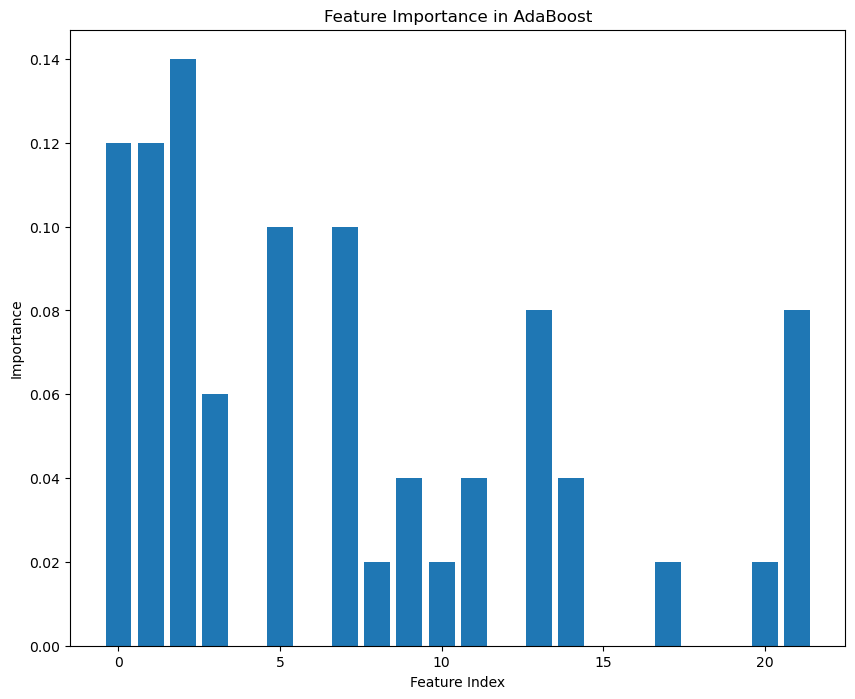

In [14]:
# Plotting feature importance (optional)
import matplotlib.pyplot as plt

feature_importances = boosting_pipeline.named_steps['classifier'].feature_importances_
plt.figure(figsize=(10, 8))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance in AdaBoost')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

#F1 scorer
f1 = make_scorer(f1_score , average='macro')

param_grid = {
    'classifier__n_estimators': [75,200,500],  # Number of trees in the forest
    'classifier__max_depth': [8,10,60],
    #'classifier__min_samples_leaf': [2,5,40],
    #'classifier__min_samples_split': [5,7]
}

# Perform grid search
grid_search = GridSearchCV(ensemble_pipeline, param_grid, cv=5, scoring=f1,n_jobs=-1,verbose=3)
grid_search.fit(X_train_predictions,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

**Example Codes**

**Visualizations**

**Hyperparameter Tuning**